# I. Random Graph Model Testing

In [44]:
%run functions_1.ipynb

Part 1 functions imported.


In [45]:
import matplotlib
font = {'size': 40}
matplotlib.rc('font', **font)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.dpi']=50

In [46]:
# For this task use the full weight matrix V.
adj_matrix = np.genfromtxt("data/sgb128Nodes41to80_weight.txt", delimiter=' ', skip_header=1)
G = nx.Graph(adj_matrix)
V = nx.adjacency_matrix(G).todense()

In [47]:
# 1. Order edges according to their weight. For this, create a matrix E of size
# n(n−1)/2 x 2 that contains the ordered list of edges so that (E(1,1),E(1,2))
# is an edge with the largest weight;
n = len(V)
E = list(G.edges(data=True))
E.sort(key=lambda e:e[2]["weight"], reverse=True)
print(n*(n-1)//2, len(E))
print(E[:10])

780 780
[(14, 38, {'weight': 0.956283}), (18, 39, {'weight': 0.926507}), (5, 18, {'weight': 0.901203}), (0, 36, {'weight': 0.891121}), (10, 32, {'weight': 0.89055}), (30, 31, {'weight': 0.876175}), (2, 35, {'weight': 0.865384}), (5, 39, {'weight': 0.837182}), (25, 37, {'weight': 0.836497}), (0, 1, {'weight': 0.830608})]


In [49]:
from collections import Counter
q3, q4, ER3, ER4, SSBM3, SSBM4 = [], [], [], [], [], []
a_list, b_list = [], []
p1_list, p2_list = [], []

debug_P = True
num_3_4_cliques = Counter()
G_sub = nx.Graph()
u, v, _ = E[0]
G_sub.add_edge(u, v)
# 2. Loop with k from 2 to n(n − 1)/2 and for each k, perform the following
# tasks on the set of first k edges, E(1 : k, 1 : 2):
for k in range(1,len(E)):
    # (a) compute the actual number of 3-cliques q3(k) and 4-cliques q4(k);
    G_sub, num_3_4_cliques = count_3_4_cliques(G_sub, num_3_4_cliques, E[k])
    q3.append(num_3_4_cliques[3])
    q4.append(num_3_4_cliques[4])
    
    num_nodes, num_edges = G.number_of_nodes(), k+1
    
    # (b) Under the Erdos-Renyi random graph model, estimate the parameter
    # p. Compute the estimated number of 3-cliques and 4-cliques (under
    # the Erdos-Renyi model), say ER3(k) and ER4(k);
    p = erdos_reyni_p_MLE(num_edges, num_nodes)
    ER3.append(erdos_reyni_estimated_q_cliques(3, num_nodes, p))
    ER4.append(erdos_reyni_estimated_q_cliques(4, num_nodes, p))
               
    # (c) Under the SSBM random graph model, estimate the parameters a
    # and b based on the number of vertices, edges, and 3-cliques, using
    # the Modified Constrained Moment Matching Algorithm 2. Compute
    # the estimated number of 3-cliques and 4-cliques (under the SSBM
    # model), say SSBM 3(k) and SSBM 4(k);
    if debug_P: 
        a, b, P1, P2 = ssbm_a_b_CMM(num_nodes, num_edges, num_3_4_cliques[3], output_P=True)
    else:
        a, b = ssbm_a_b_CMM(num_nodes, num_edges, num_3_4_cliques[3], output_P=False) 

    a_list.append(a)
    b_list.append(b)
    
    SSBM3.append(ssbm_estimated_q_cliques(3, num_nodes, a, b))
    SSBM4.append(ssbm_estimated_q_cliques(4, num_nodes, a, b))
    
    if k%50 == 0: print(f"subset {k} out of {len(E)} complete")

subset 50 out of 780 complete
subset 100 out of 780 complete
subset 150 out of 780 complete
subset 200 out of 780 complete
subset 250 out of 780 complete
subset 300 out of 780 complete
subset 350 out of 780 complete
subset 400 out of 780 complete
subset 450 out of 780 complete
subset 500 out of 780 complete
subset 550 out of 780 complete
subset 600 out of 780 complete
subset 650 out of 780 complete
subset 700 out of 780 complete
subset 750 out of 780 complete


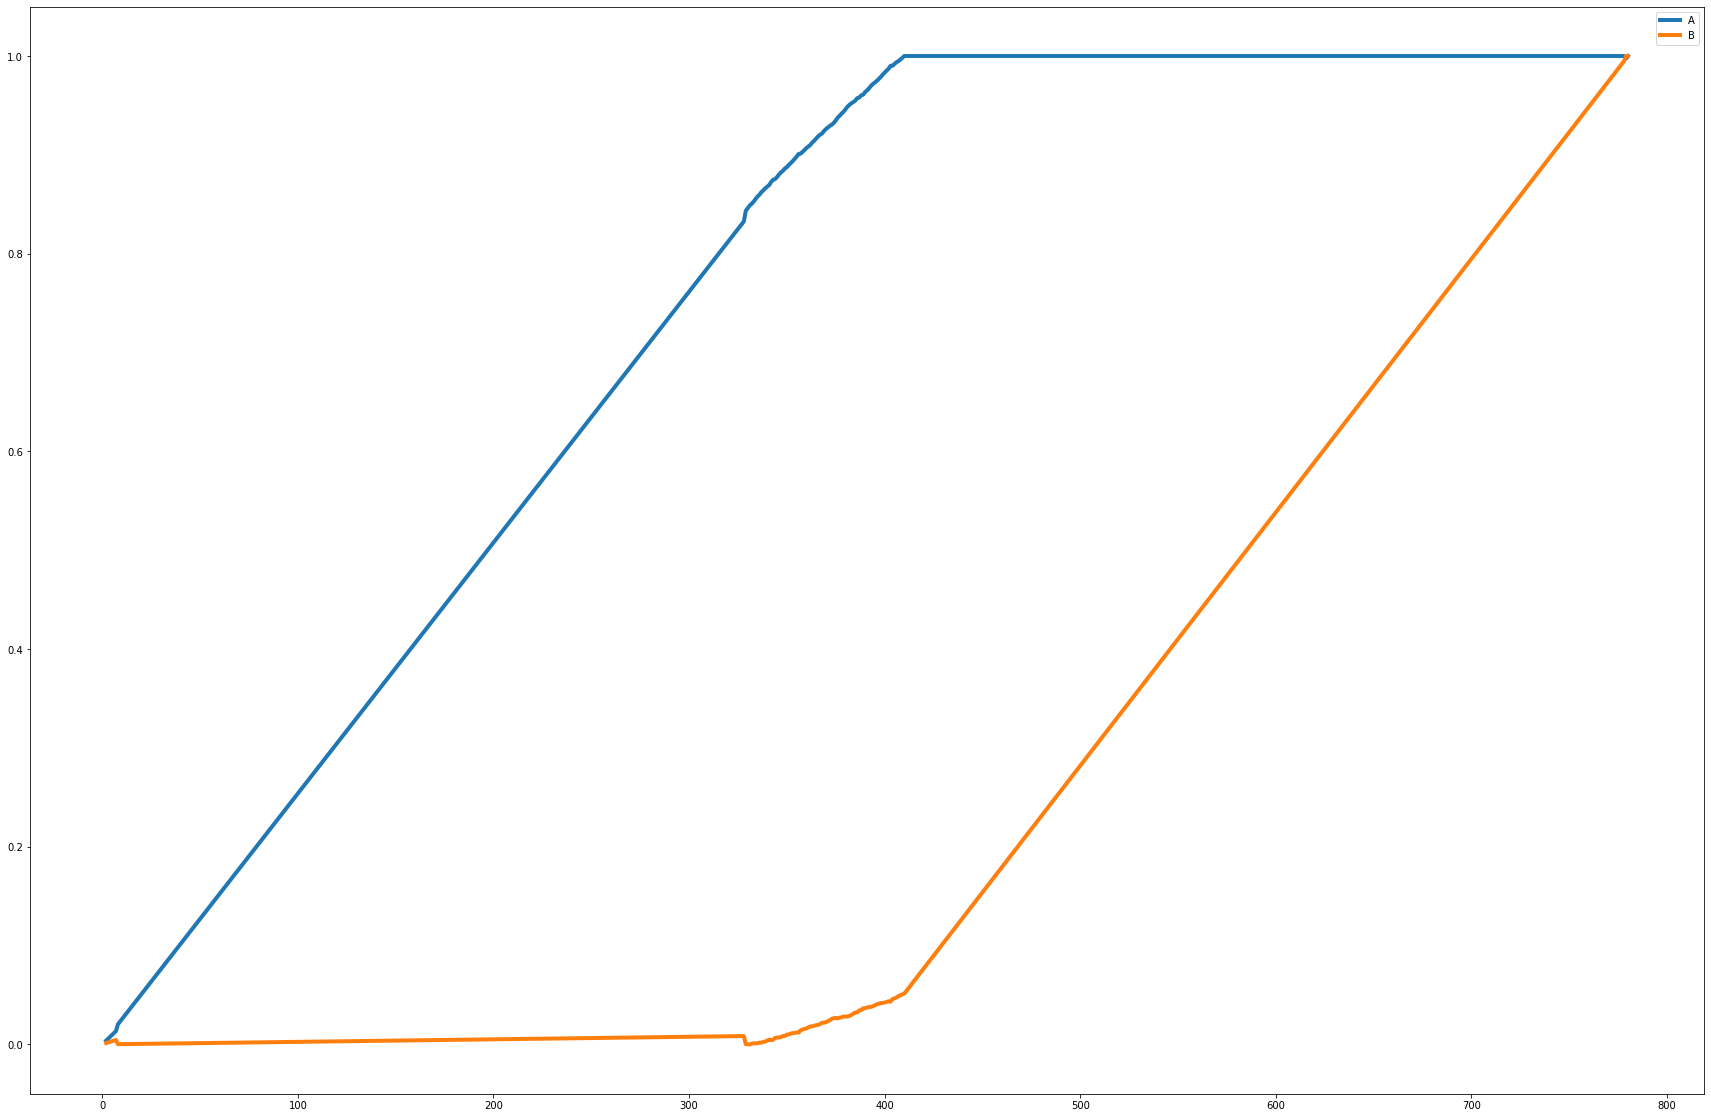

In [25]:
# Test plot of a and b estimated values
plt.figure(figsize=(30,20))
k = list(range(2, len(E)+1))

plt.plot(k, a_list, label="A", linewidth=4)
plt.plot(k, b_list, label="B", linewidth=4)
plt.legend()
plt.show()

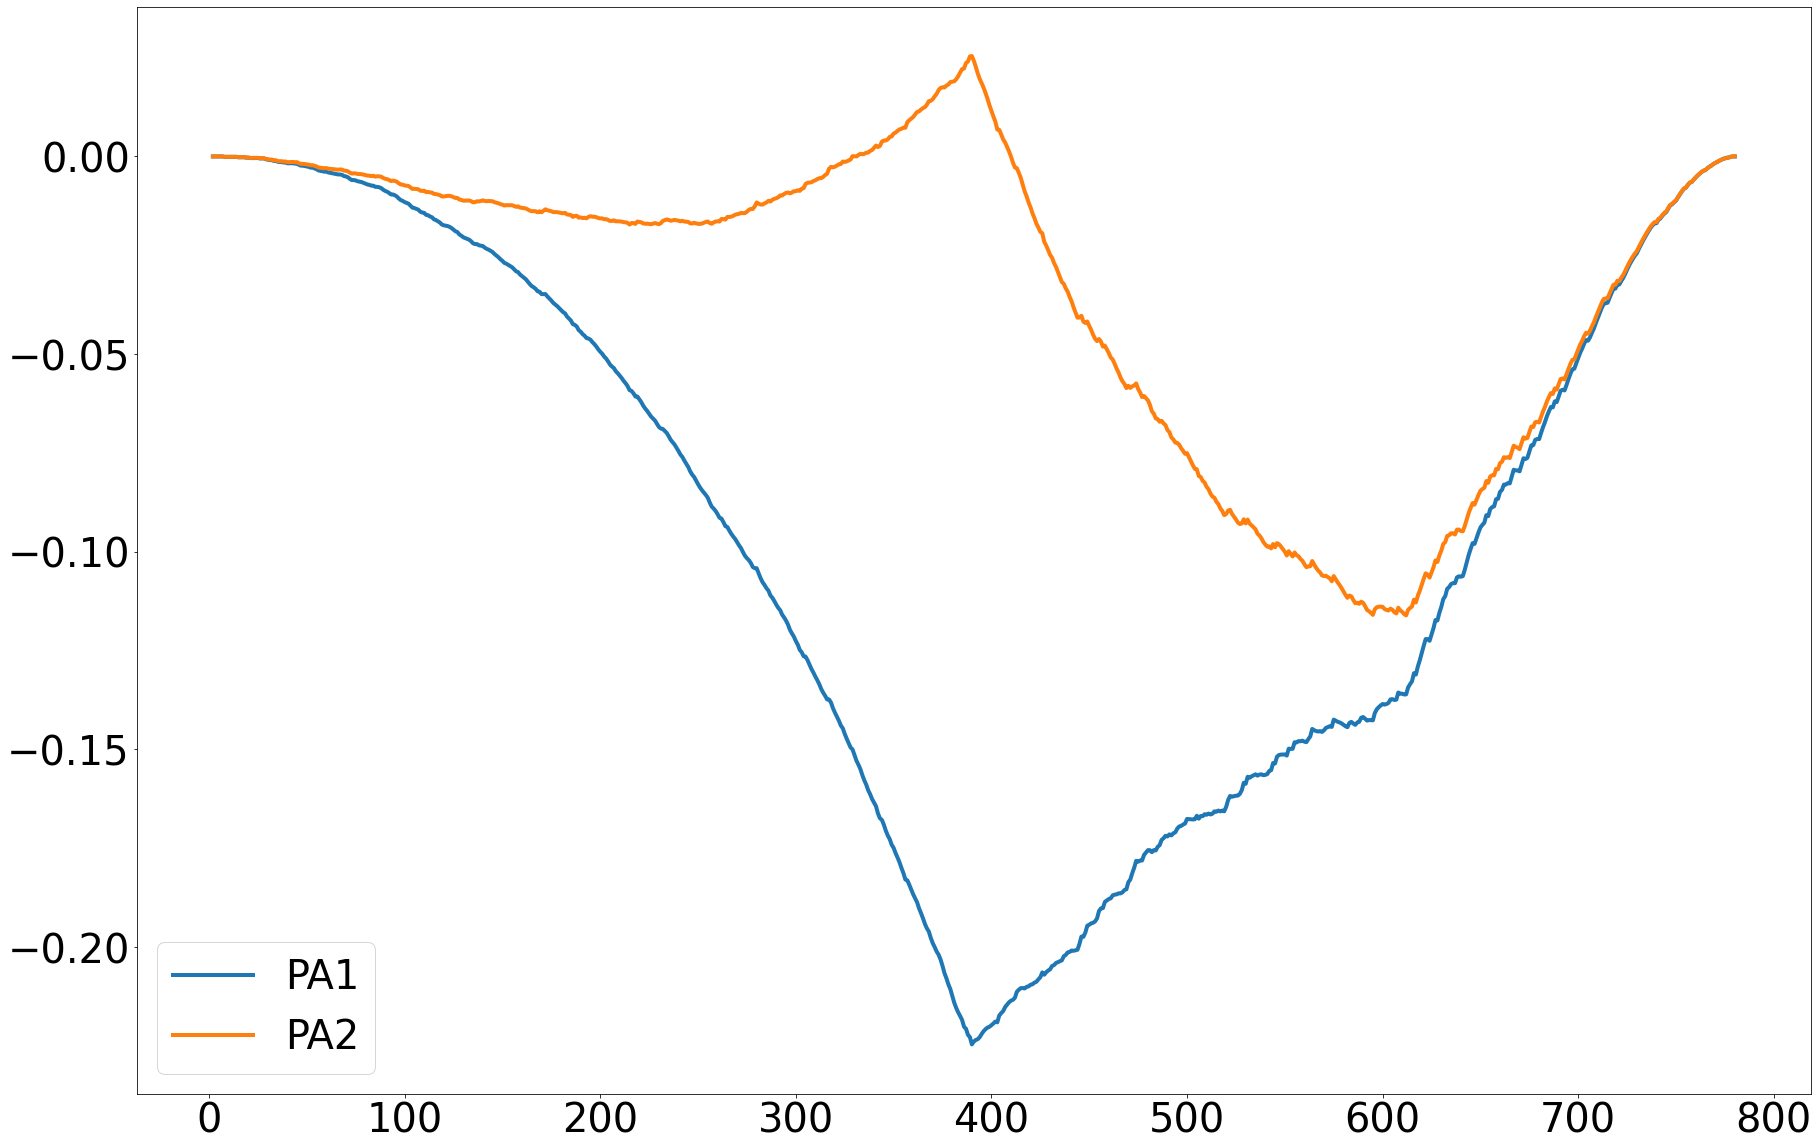

In [50]:
# Test plot of a and b estimated values
plt.figure(figsize=(30,20))
k = list(range(2, len(E)+1))

plt.plot(k, a_list, label="PA1", linewidth=4)
plt.plot(k, b_list, label="PA2", linewidth=4)
plt.legend()
plt.show()

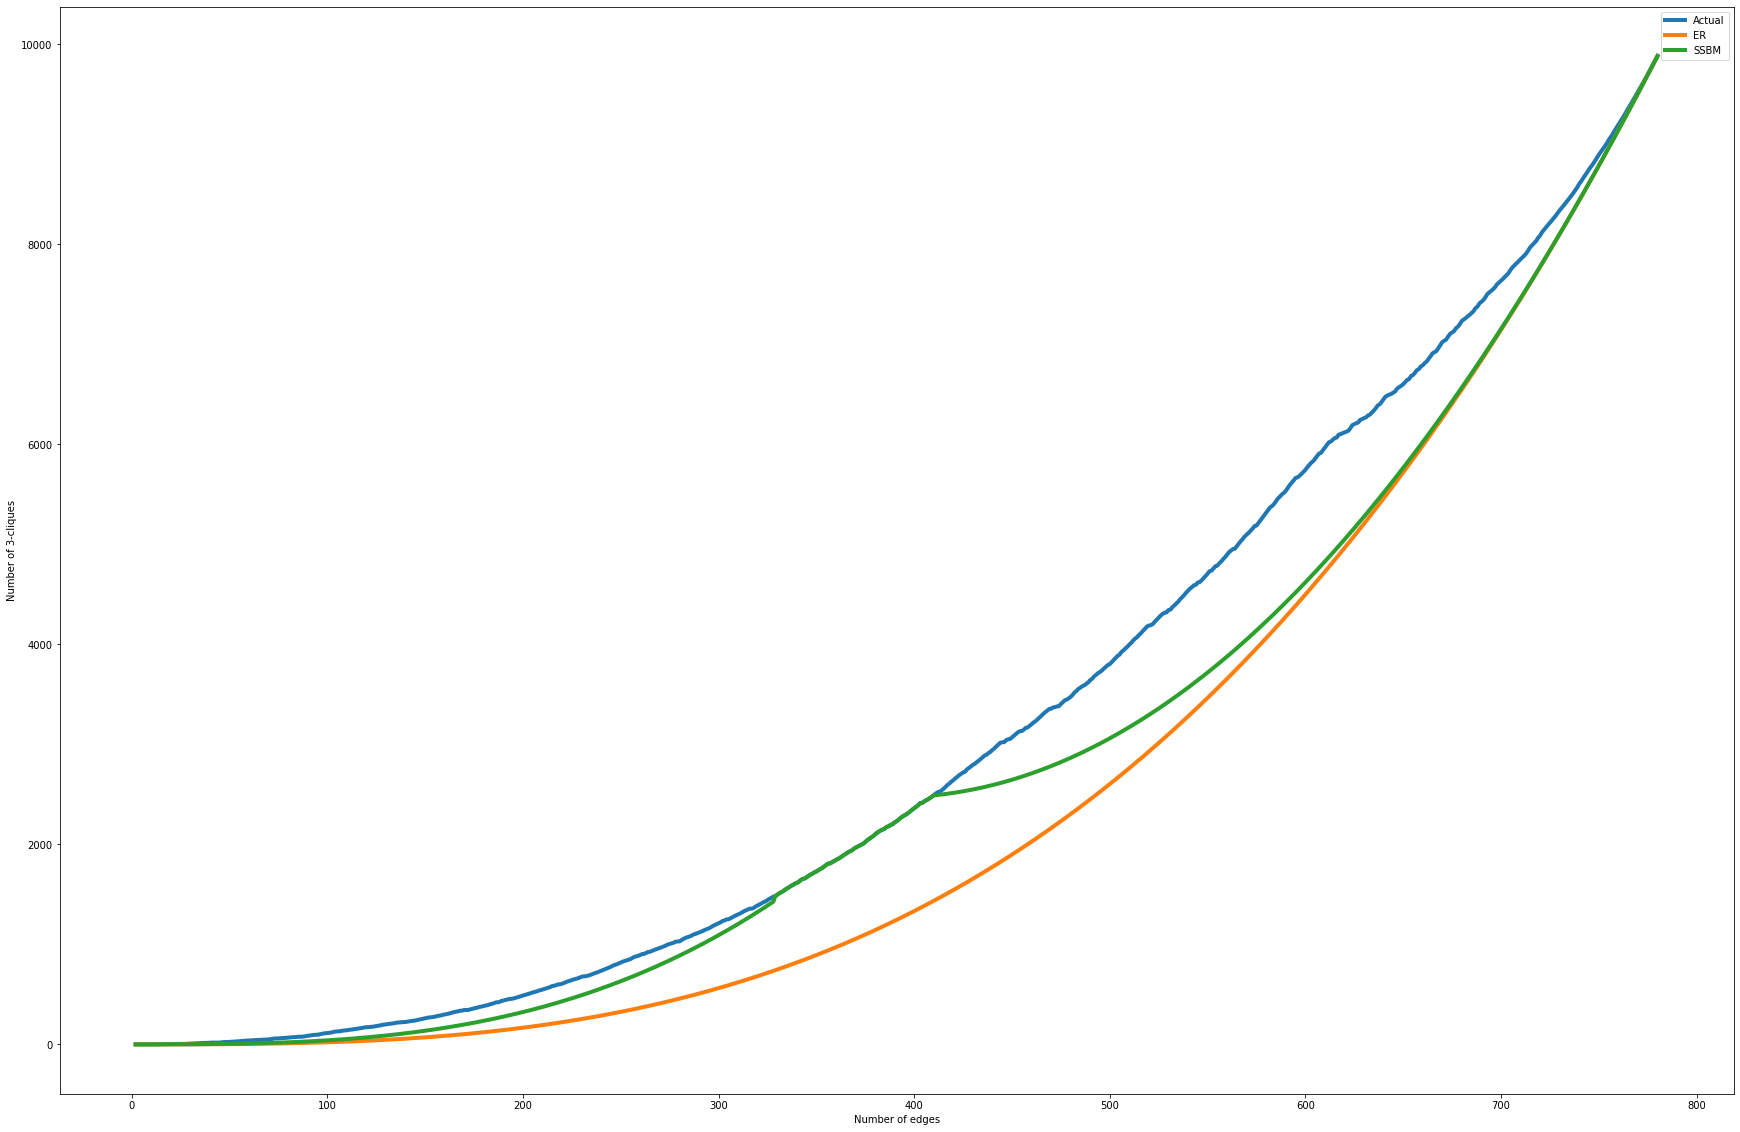

In [10]:
# 3. Plot q3, ER3 and SSBM 3 on the same plot. Estimate the amplitude
# C and exponent r from the power law y(k) ∼ Ck^r by a linear fit in the
# log-log plot, after you discard the first, say 10 entries. Call C3,ER, r3,ER
# and C3,SSBM, r3,SSBM the respective parameters.

# TODO: Discard the first few values
k = list(range(2, len(E)+1))
plt.figure(figsize=(30,20))
plt.plot(k, q3, label="Actual", linewidth=4)
plt.plot(k, ER3, label="ER", linewidth=4)
plt.plot(k, SSBM3, label="SSBM", linewidth=4)
plt.xlabel("Number of edges", )
plt.ylabel("Number of 3-cliques")
plt.legend()
plt.savefig("images/3_clique_er_ssbm.png")

In [36]:
from scipy.stats import linregress

log_transform = lambda vals, discard_first_n=discard_first_n: \
    list(map(np.log,vals[discard_first_n:]))

def exponential_fit_coefficients(vals, discard_first_n):
    vals_log = log_transform(vals)
    k_log = log_transform(k)
    # log(y) = a*log(k) + b
    # y = e^(a*log(k) + b) = (e^(a*log(k))*(e^b) = (e^b)*(k^a)
    result = linregress(k_log, vals_log)
    C, r = np.exp(result.intercept), result.slope
    return C, r 

exponential_fit = lambda C, r, discard_first_n: \
    [np.log(C)+r*np.log(k) for k in k[discard_first_n:]]

In [12]:
discard_first_n = 10

C3, r3 = exponential_fit_coefficients(q3, discard_first_n)
print(f"C3:      {C3:f}, r3:      {r3:f}")

C3_ER, r3_ER = exponential_fit_coefficients(ER3, discard_first_n)
print(f"C3_ER:   {C3_ER:f}, r3_ER:   {r3_ER:f}") 

C3_SSBM, r3_SSBM = exponential_fit_coefficients(SSBM3, discard_first_n)
print(f"C3_SSBM: {C3_SSBM:f}, r3_SSBM: {r3_SSBM:f}") 

C3:      0.004474, r3:      2.195155
C3_ER:   0.000021, r3_ER:   3.000000
C3_SSBM: 0.000134, r3_SSBM: 2.743109


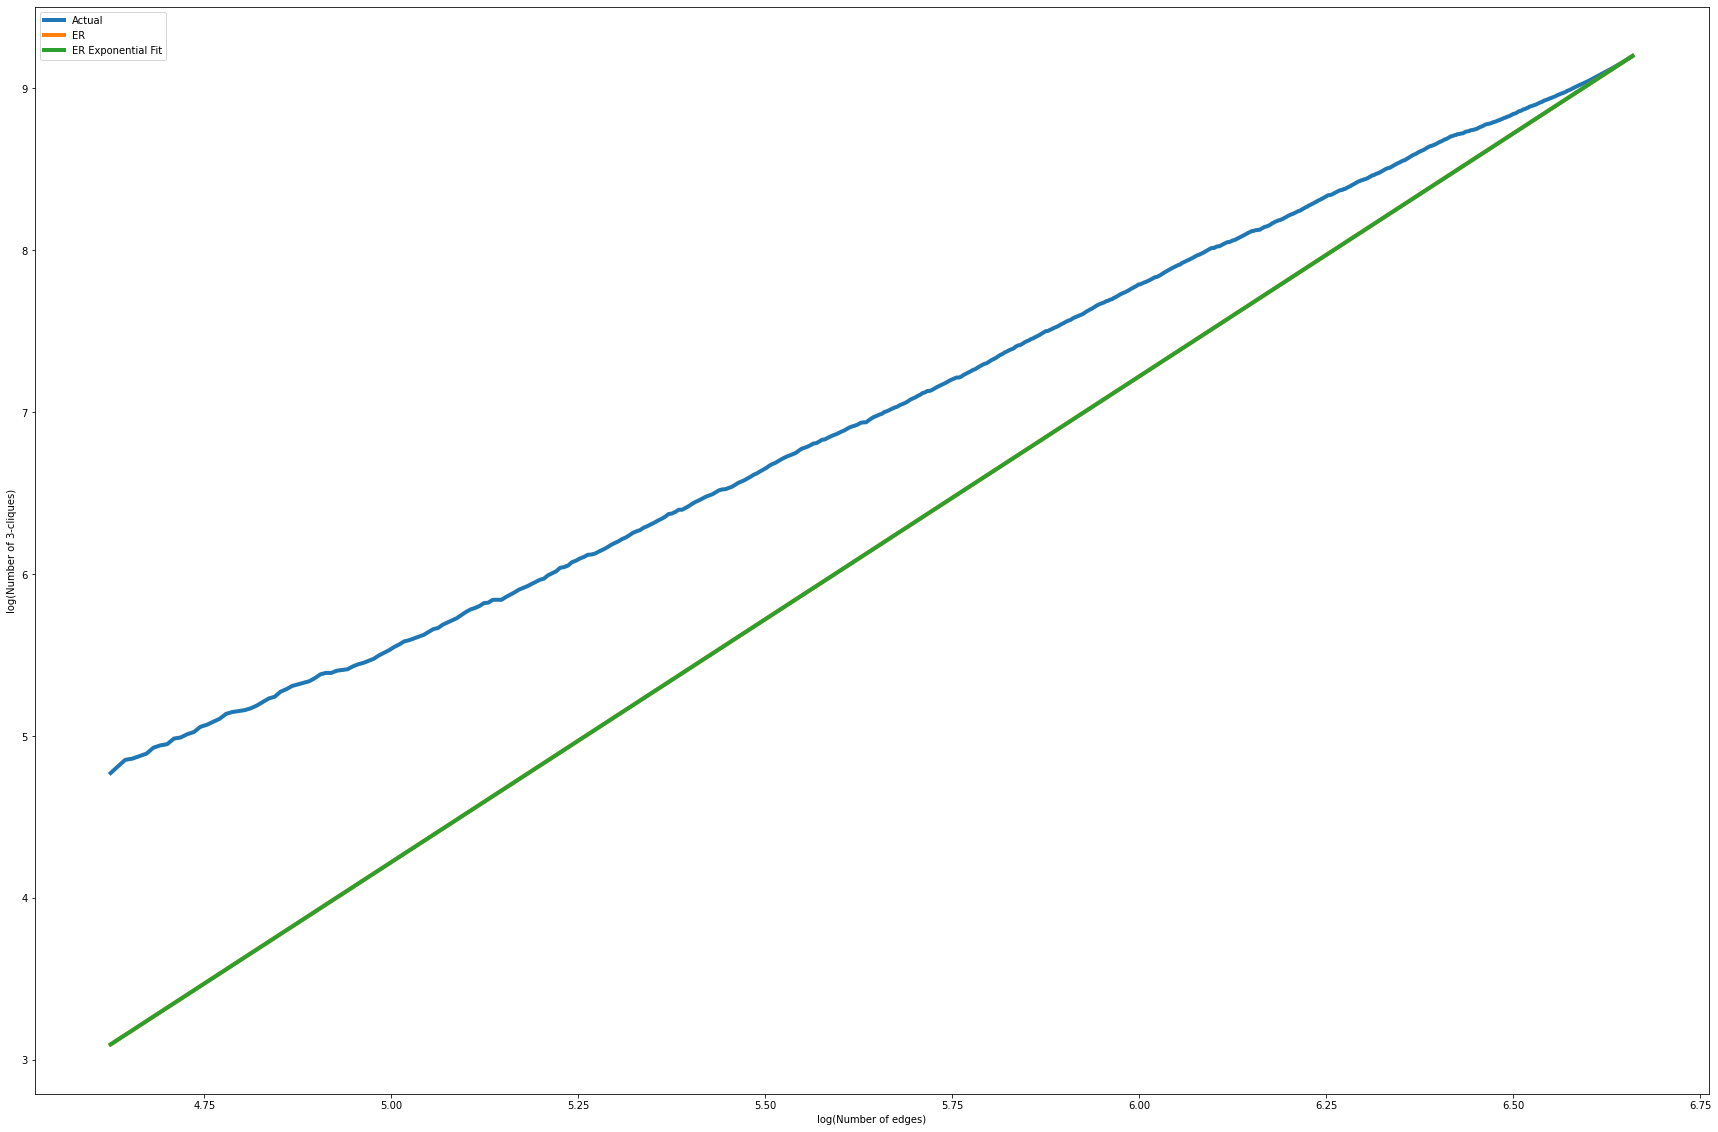

In [28]:
# 4. Plot log(q3), log(ER3) and log(C3,ER) + r3,ERlog(k) on same figure over
# the range of k utilized to estimate the exponent.
k_log = log_transform(k)
plt.figure(figsize=(30,20))
plt.plot(k_log, log_transform(q3), linewidth=4, label="Actual")
plt.plot(k_log, log_transform(ER3), linewidth=4, label="ER")
plt.plot(k_log, exponential_fit(C3_ER, r3_ER, discard_first_n), 
         linewidth=4, label="ER Exponential Fit")
plt.xlabel("log(Number of edges)")
# TODO: Add exponential fit for the true data
plt.ylabel("log(Number of 3-cliques)")
plt.legend()
plt.savefig("images/log_3_clique_er.png")

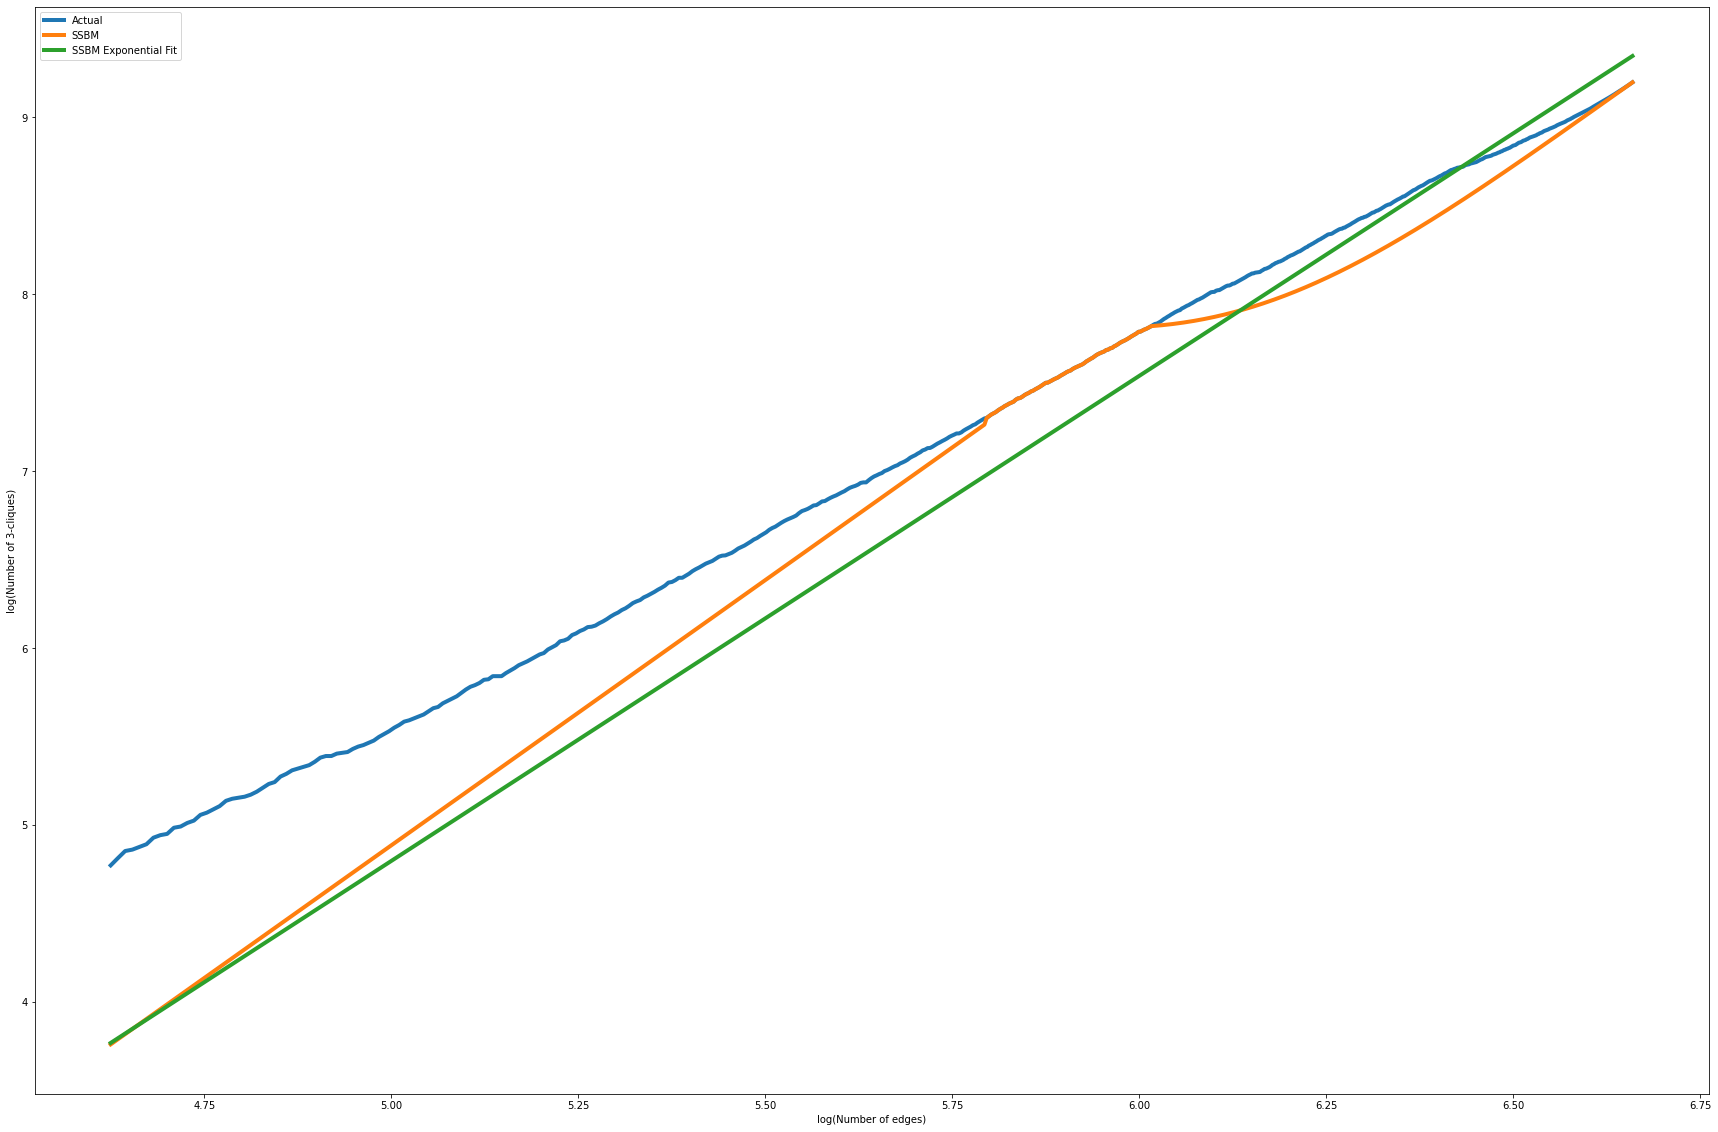

In [29]:
# 5. Plot log(q3), log(SSBM 3) and log(C3,SSBM ) + r3,SSBM log(k) on same
# figure over the range of k utilized to estimate the exponent.
plt.figure(figsize=(30,20))
plt.plot(k_log, log_transform(q3), linewidth=4, label="Actual")
plt.plot(k_log, log_transform(SSBM3), linewidth=4, label="SSBM")
plt.plot(k_log, exponential_fit(C3_SSBM, r3_SSBM, discard_first_n), 
         linewidth=4, label="SSBM Exponential Fit")
plt.xlabel("log(Number of edges)")
plt.ylabel("log(Number of 3-cliques)")
plt.legend()
plt.savefig("images/log_3_clique_ssbm.png")

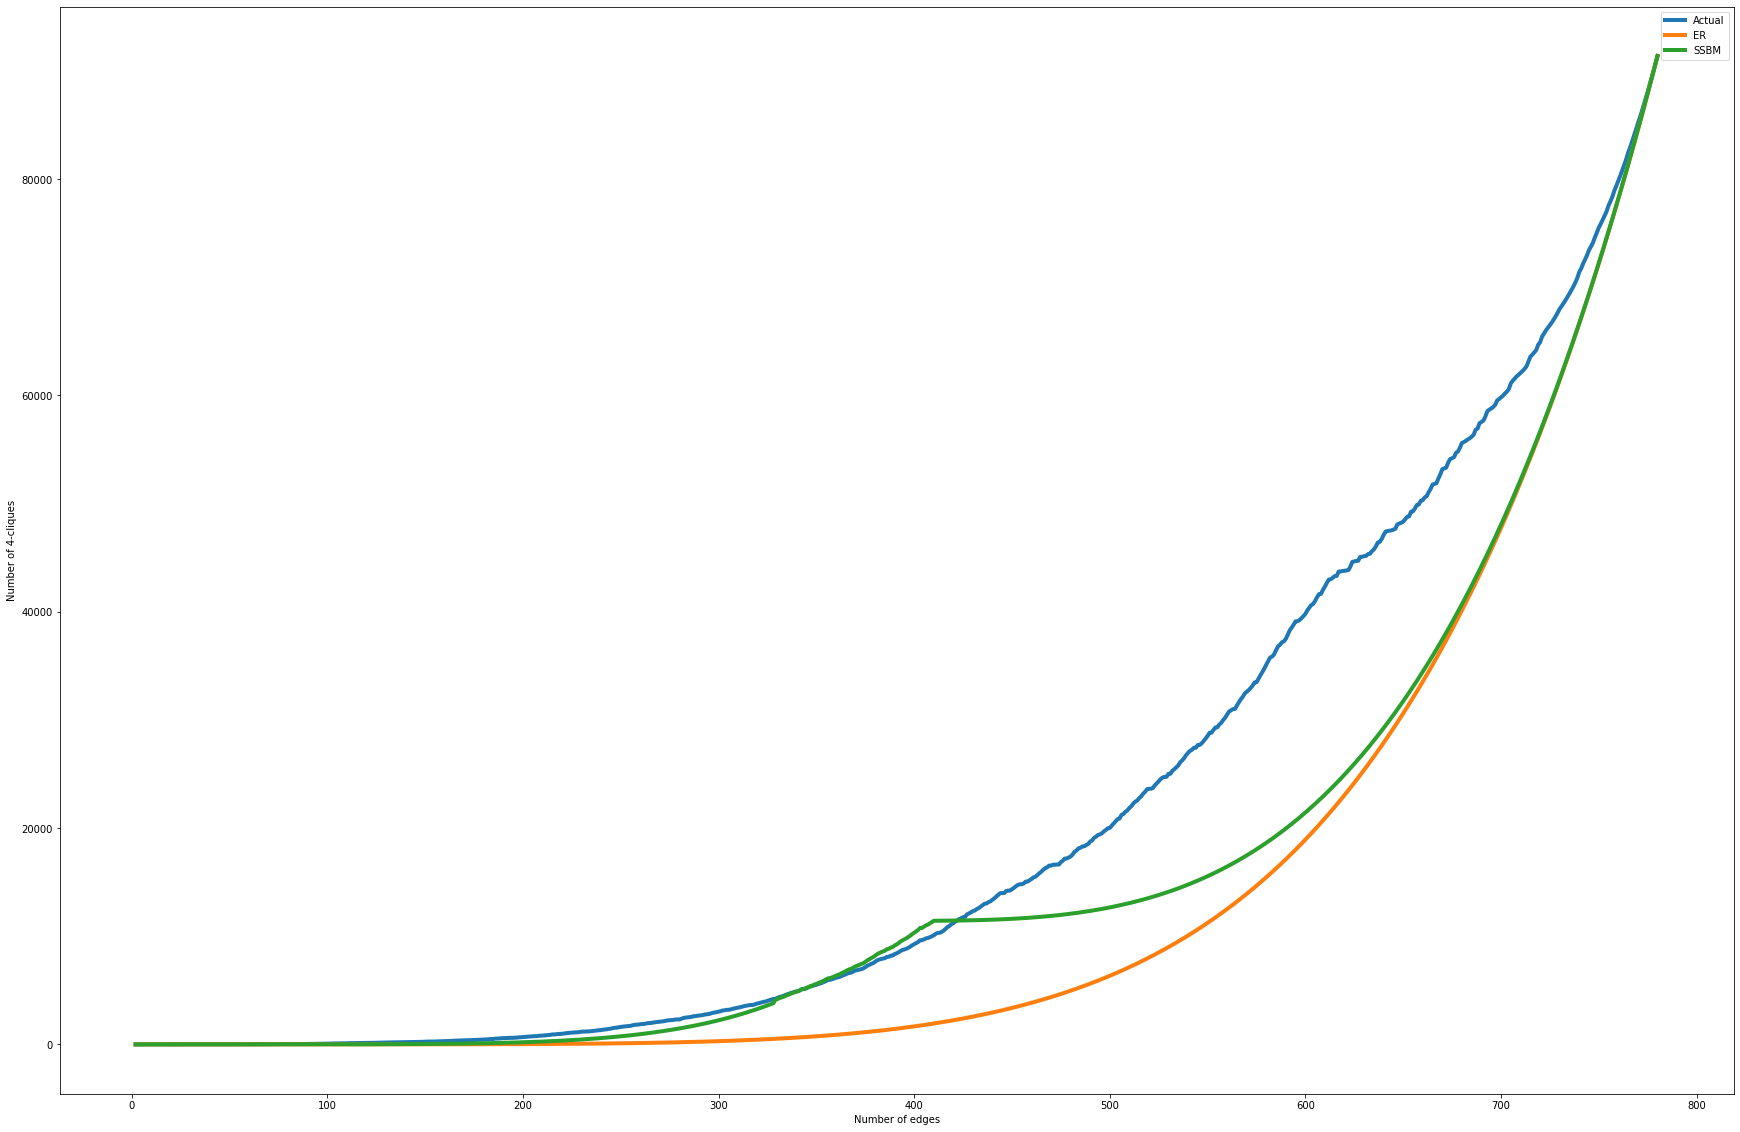

In [15]:
# 6. Plot q4, ER4 and SSBM 4 on the same plot. Estimate the exponent r
# from the power law y(k) ∼ Ckr by a linear fit in the log-log plot, after you
# discard, say 100 first entries. Call C4,ER, r4,ER and C4,SSBM , r4,SSBM
# the respective parameters.
plt.figure(figsize=(30,20))
plt.plot(k, q4, label="Actual", linewidth=4)
plt.plot(k, ER4, label="ER", linewidth=4)
plt.plot(k, SSBM4, label="SSBM", linewidth=4)
plt.xlabel("Number of edges")
plt.ylabel("Number of 4-cliques")
plt.legend()
plt.savefig("images/4_clique_er_ssbm.png")

In [16]:
discard_first_n = 100

C4_ER, r4_ER = exponential_fit_coefficients(ER4, discard_first_n)
print(f"C4_ER:   {C4_ER:e}, r4_ER:   {r4_ER:f}") 

C4_SSBM, r4_SSBM = exponential_fit_coefficients(SSBM4, discard_first_n)
print(f"C4_SSBM: {C4_SSBM:e}, r4_SSBM: {r4_SSBM:f}") 

C4_ER:   4.058178e-13, r4_ER:   6.000000
C4_SSBM: 6.281710e-09, r4_SSBM: 4.571289


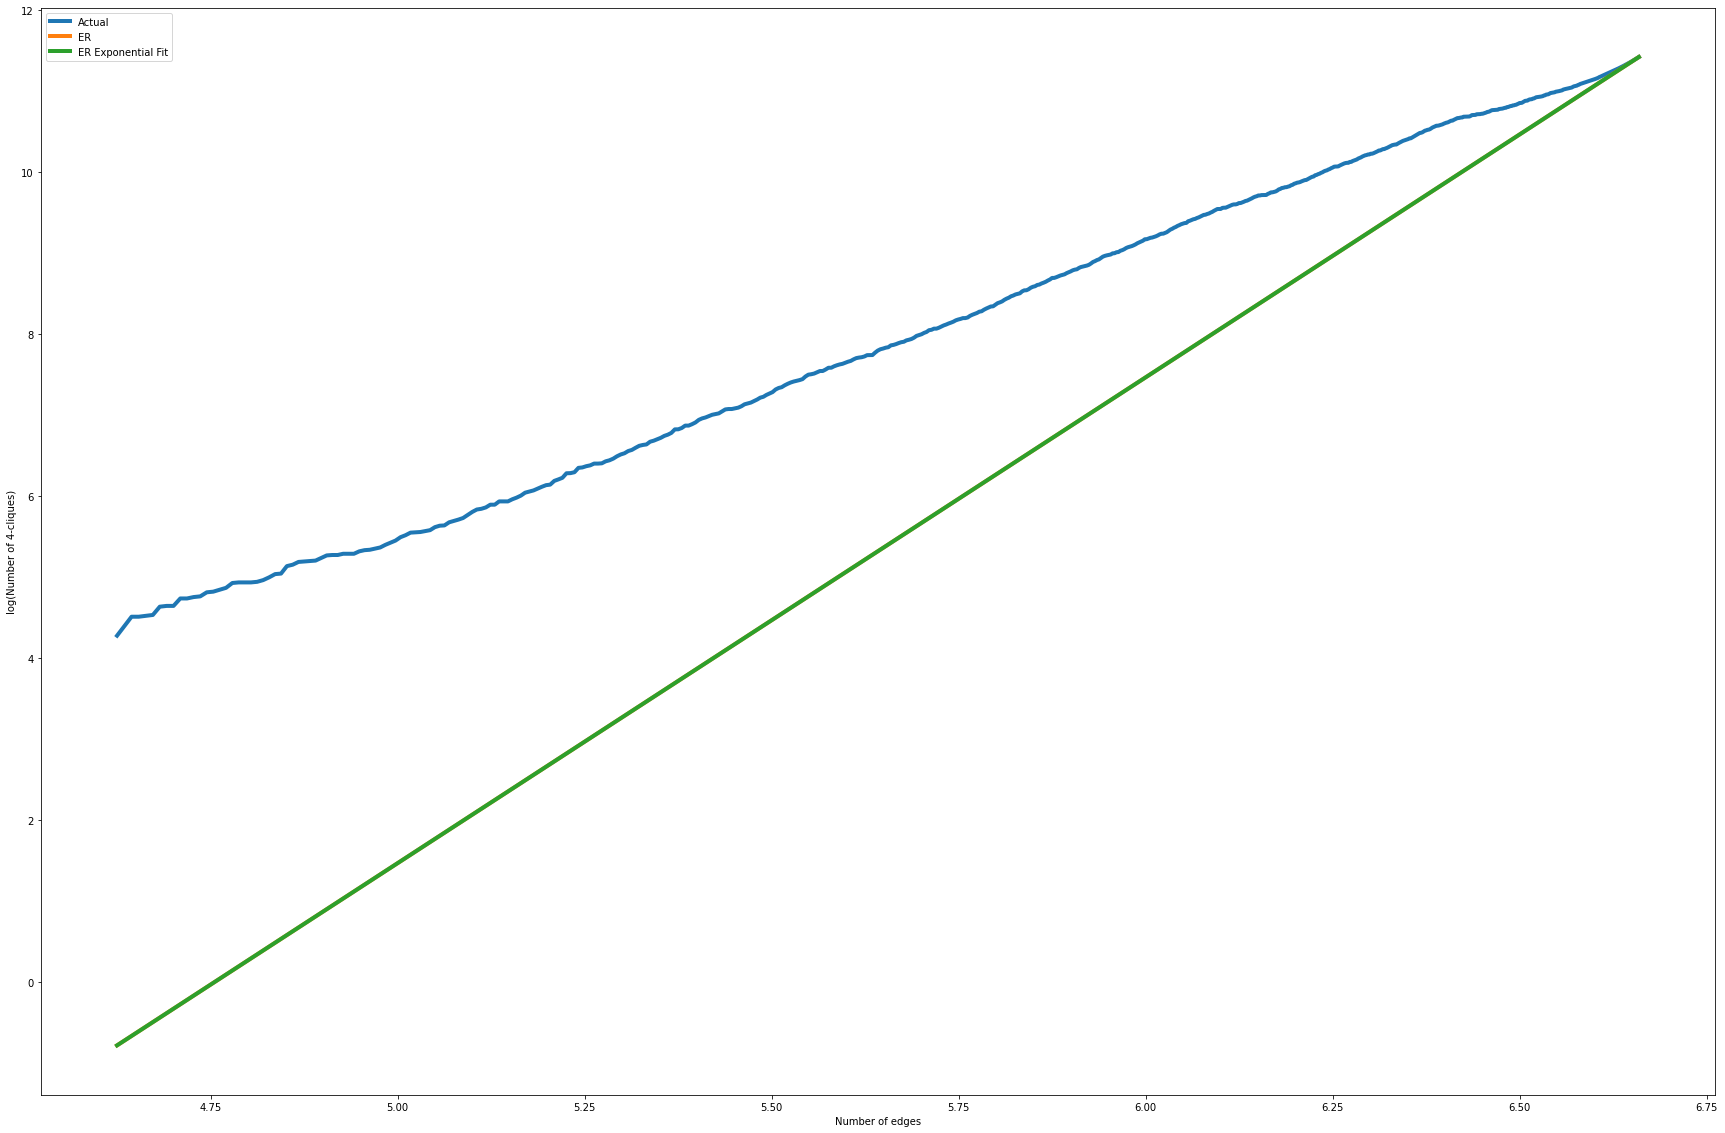

In [37]:
# 7. Plot log(q4), log(ER4) and log(C4,ER) + r4,ERlog(k) on same figure over
# the range of k utilized to estimate the exponent.
k_log = log_transform(k, discard_first_n)
plt.figure(figsize=(30,20))
plt.plot(k_log, log_transform(q4), linewidth=4, label="Actual")
plt.plot(k_log, log_transform(ER4), linewidth=4, label="ER")
plt.plot(k_log, exponential_fit(C4_ER, r4_ER, discard_first_n), 
         linewidth=4, label="ER Exponential Fit")
plt.xlabel("Number of edges")
plt.ylabel("log(Number of 4-cliques)")
plt.legend()
plt.savefig("images/log_4_clique_er.png")

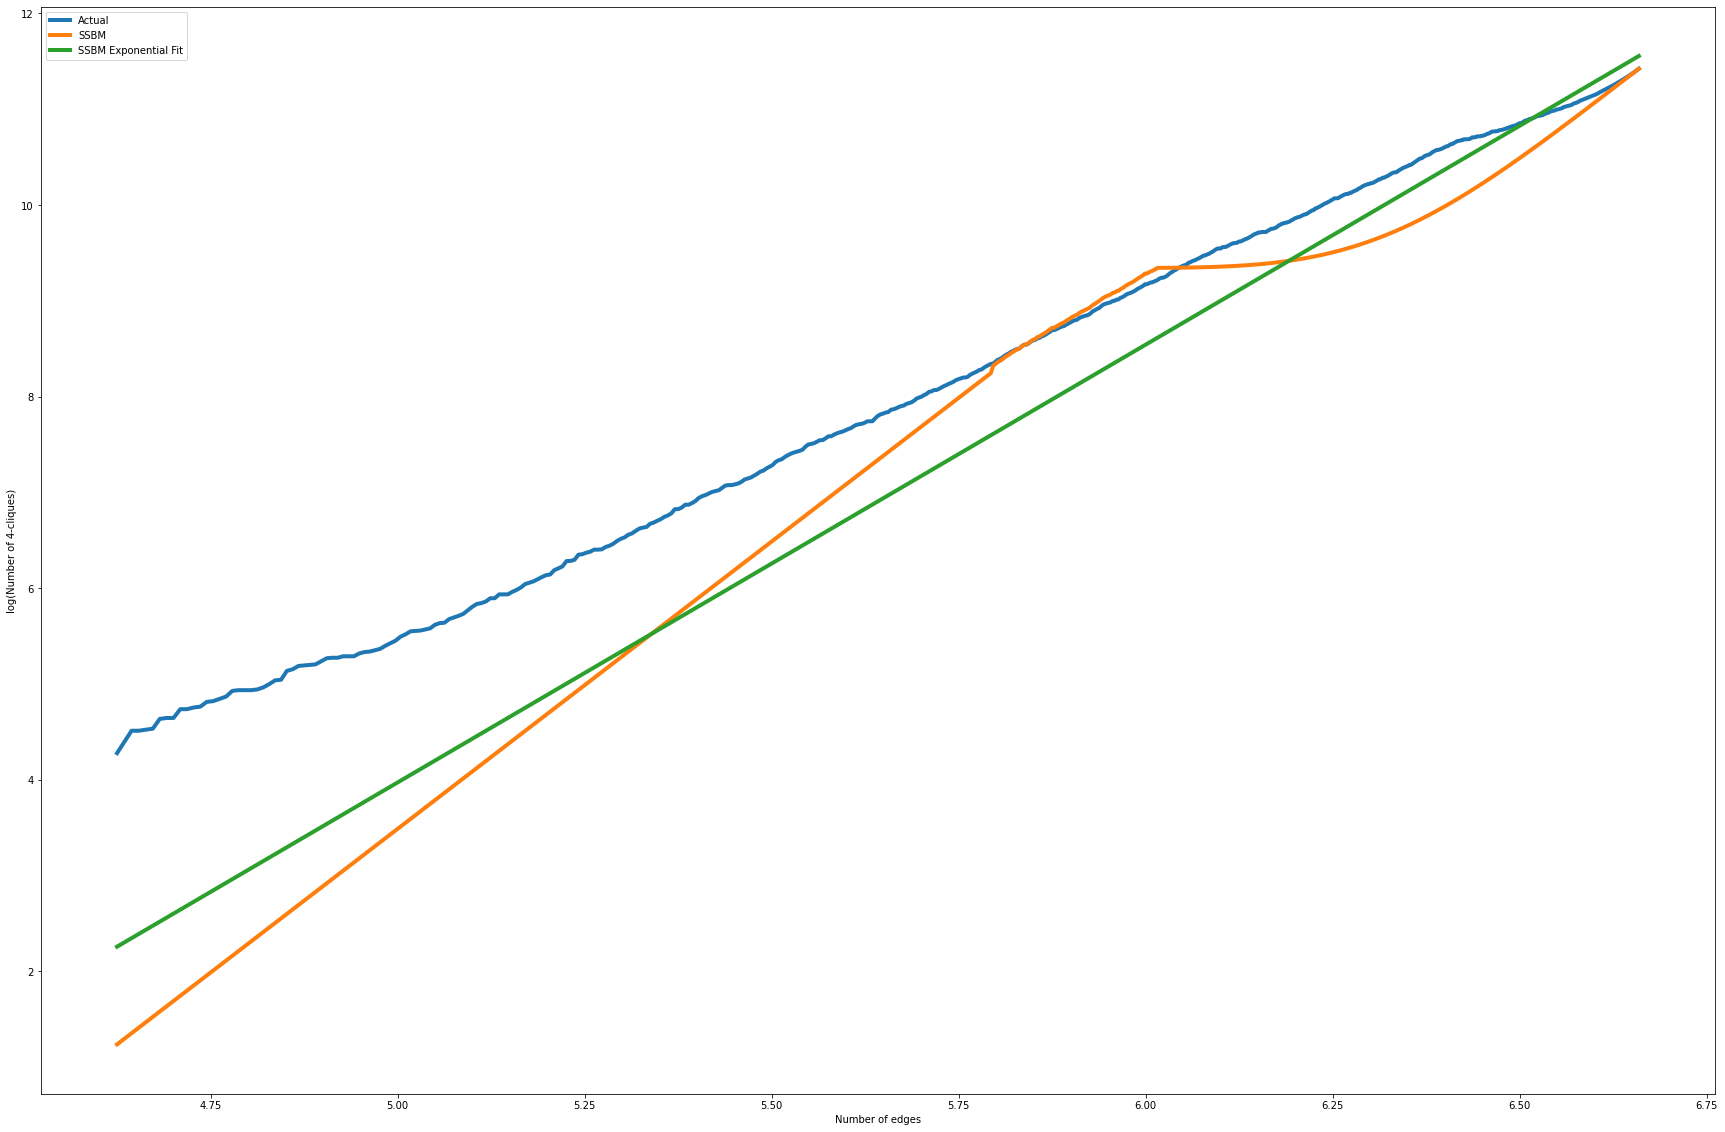

In [38]:
# 8. Plot log(q4), log(SSBM 4) and log(C4,SSBM ) + r4,SSBM log(k) on same
# figure over the range of k utilized to estimate the exponent.
k_discard_first_n = list(map(np.log,k[discard_first_n:]))
plt.figure(figsize=(30,20))
plt.plot(k_discard_first_n, log_transform(q4), linewidth=4, label="Actual")
plt.plot(k_discard_first_n, log_transform(SSBM4), linewidth=4, label="SSBM")
plt.plot(k_discard_first_n, exponential_fit(C4_SSBM, r4_SSBM, discard_first_n), 
         linewidth=4, label="SSBM Exponential Fit")
plt.xlabel("Number of edges")
plt.ylabel("log(Number of 4-cliques)")
plt.legend()
plt.savefig("images/log_4_clique_ssbm.png")

In [39]:
# Which of the two random graph model fits better the data? Why do you think
# I recommend to discard the first 10 or 100 entries?

By inspecting the graphs, it seems that the ER model produces a better fit for 3-cliques, while the models are equally poor at estimating 4-cliques.
To determine which is a better fit quantitatively, we can find the mean squared residuals:

In [40]:
# TODO: Figure out why some of the values are imaginary
list(filter(lambda elm: isinstance(elm, complex), SSBM3))

[(-1.6345088904047827e-19+3.2690177808095654e-20j),
 (-6.538035561619131e-19+1.3076071123238261e-19j),
 (-1.3076071123238261e-18+2.6152142246476523e-19j),
 (-2.353692802182887e-18+1.046085689859061e-18j),
 (-3.661299914506713e-18+1.046085689859061e-18j),
 (-5.2304284492953046e-18+2.092171379718122e-18j)]

In [41]:
list(map(SSBM3.index, list(filter(lambda elm: isinstance(elm, complex), SSBM3))))

[0, 1, 2, 3, 4, 5]

The first few sets of edges produce imaginary results.

In [42]:
from statistics import mean
mean_sq_res = lambda est, act: mean((e.real-a)**2 for e, a in zip(est,act))

print(f"MSR for 3-cliques, ER: {mean_sq_res(ER3, q3):e}; SSBM: {mean_sq_res(SSBM3, q4):e}")  
print(f"MSR for 4-cliques, ER: {mean_sq_res(ER4, q4):e}; SSBM: {mean_sq_res(SSBM4, q4):e}")  

MSR for 3-cliques, ER: 6.139014e+05; SSBM: 7.886178e+08
MSR for 4-cliques, ER: 1.043081e+08; SSBM: 6.494793e+07


The mean squared residuals for the Erdos-Reyni model are smaller than the Symmetric Stochastic Block Model for 3-cliques, but the SSBM model has a higher error on 4-cliques... \[TODO\]

We should discard the first few entries because the first few values are likely to be zero, and log(0) is undefined:

In [23]:
print(*q3[:10])

0 0 0 0 0 0 1 1 1 1


In [24]:
print(*q4[:100])

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 3 3 3 3 3 3 6 7 7 7 7 7 8 8 9 10 13 13 13 13 13 14 14 14 14 14 14 14 14 17 17 18 24 27 27 27 28 28 28 28 29 30 30 31 31 34 34 34 35 39 42 43 46 50 50 50 52 60 66 67 70 71
